<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

A diferencia del código anterior, este modelo trabaja sobre estados térmicos

## Código base

In [93]:
import tensorflow as tf
num_gpus = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(num_gpus[0],True)
import sys
import platform
print(sys.version)

3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


Cargamos el código de Bosonic.py básico, branch fermionic

In [94]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math
import tensorflow_probability as tfp
import tensorflow as tf
from tqdm import tqdm
from itertools import combinations
import scipy

# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return sorted_base

def custom_base_representation_tf(n_min, n_max, base, num_digits):
    # Generate a range of numbers from n_min to n_max
    numbers = tf.range(n_min, n_max + 1, dtype=tf.int64)
    
    # Calculate the digits in the custom base using broadcasting
    digits = tf.pow(tf.cast(base, dtype=tf.float64), tf.cast(tf.range(num_digits), dtype=tf.float64))
    
    # Reshape the digits to [1, num_digits] for broadcasting
    digits = tf.reshape(digits, [1, -1])
    
    # Reshape numbers to [batch_size, 1]
    numbers = tf.reshape(tf.cast(numbers, dtype=tf.float64), [-1, 1])
    
    # Calculate the digits in the custom base for each number using broadcasting
    result = tf.cast(tf.math.floormod(tf.math.floordiv(numbers, digits), base), dtype=tf.int32)
    
    # Pad the result to have exactly num_digits columns
    result = tf.pad(result, paddings=[[0, 0], [0, num_digits - tf.shape(result)[1]]], constant_values=0)
    
    # Reverse the order of columns
    #result = tf.reverse(result, axis=[1])

    return result

def select_rows_with_sum(arr, m):
    # Create a mask based on the criteria
    mask = tf.reduce_all(tf.math.logical_or(tf.equal(arr, 0), tf.equal(arr, 1)), axis=1) & (tf.reduce_sum(arr, axis=1) == m)
    
    # Use the mask to select the rows
    result = tf.boolean_mask(arr, mask, axis=0)
    
    return result

def create_basis_tf_(m, d):
    base = []
    index = 0
    chunk_size = 10000000
    for x in tqdm(range(0,(m+1)**d, chunk_size)):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        res = custom_base_representation_tf(start_index, end_index, m+1, d)
        arr = select_rows_with_sum(res, m)
        base.append(arr.numpy())

    return np.concatenate(base)

def create_fermionic_base_(m, d):
    indices = list(range(d))
    combinations_list = list(combinations(indices, m))
    
    vectors = []
    for combo in combinations_list:
        vector = [1 if i in combo else 0 for i in indices]
        vectors.append(vector)
    
    return vectors

# Dada una base, devuelve los vectores que estan dados de a pares
def get_kkbar_indices_(base):
    indices = []
    for i, v in enumerate(base):
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        try:
            return self.base.tolist().index(list(rep))
        except:
            return None

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d, pairs = False):
        #print("Creating basis: ", m, d)
        #base = np.array(create_basis_tf_(m, d)) CASO GENERICO
        base = np.array(create_fermionic_base_(m,d)) # UNICAMENTE FERMIONICO
        if pairs:
            base = base[get_kkbar_indices_(base)]
        length = base.shape[0]
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals
    
    def __init__(self, m, d, pairs = False):
        self.m = m
        self.d = d
        (self.base, self.canonicals) = self.create_basis(m, d, pairs)
        self.size = self.base.shape[0]

# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                #print(v)
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                if tar is None:
                    pass
                else:
                    mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i] 
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)


# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Genera las matrices de rho1
def rho_1_gen(basis):
    d = basis.d
    s = basis.size
    mat = np.empty((d,d,s,s), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            mat[i,j,:,:] = np.array(bdb(basis,j, i).todense())
    return mat

#@jit(parallel=True, nopython=True)
def rho_1(d, state, rho_1_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_1_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat


# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)

    return mat

def rho_2(size, state, rho_2_arrays):
    state_expanded = np.expand_dims(state, axis=1)
    state_expanded = np.expand_dims(state_expanded, axis=1)
    rho_2_arrays = rho_2_arrays[np.newaxis, :, :, :, :]
    print(state_expanded.shape, rho_2_arrays.shape)
    product = state_expanded * rho_2_arrays
    mat = np.sum(product, axis=(-2, -1))
    return mat

def get_kkbar_indices(t_basis):
    indices = []
    for i, v in enumerate(t_basis.base):
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

def rho_2_kkbar_gen(t_basis, rho_2_arrays):
    indices = get_kkbar_indices(t_basis)
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada

    rho_2_arrays_kkbar = rho_2_arrays[i, j, :, :]

    return rho_2_arrays_kkbar

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

#@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            # v1 = vect @ bd_m @ b_m @ vect Para estados puros
            # Mult de b's y filleo de mat
            coef = np.trace(vect @ bd_m @ b_m)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat


/tmp/ipykernel_2766/1952354829.py:326: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def gamma_lamba_inv(x):


## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [95]:
m = 4
d = 2*m
pairs = False # Usar solo para estados puros
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d, pairs = pairs)
#basis_m1 = fixed_basis(m-1, d, pairs = True)
basis_m2 = fixed_basis(m-2, d, pairs = pairs)
print(basis.size)

70


In [96]:
## Usamos este approach si queremos guardar los generadores
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
eps = 0.00001

def sym_mat_gen(vect, d):
    matrix = fill_matrix(vect, d)
    return matrix + matrix.T - np.diag(matrix.diagonal())

@jit(nopython=True)
def fill_matrix(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in prange(d):
        for j in prange(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix

# Generamos una matrix aleatoria. Cuidado con la distribución, ver https://stackoverflow.com/questions/56605189/is-there-an-efficient-way-to-generate-a-symmetric-random-matrix
def hamil_base_gen(d):
    U = np.random.uniform(low=0, high=1.0, size=(d, d))
    hamil_base = np.tril(U) + np.tril(U, -1).T
    return hamil_base

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
# Alternativamente podemos construirlo a partir de rho_1_gen
def base_hamiltonian_aux(mat, size, d, rho_1_gen):
    # Construccion de H
    rho_1_gen_transposed = rho_1_gen.transpose(1, 0, 2, 3)
    mat_expanded = mat[:, :, np.newaxis, np.newaxis]
    h = np.sum(mat_expanded * rho_1_gen_transposed[:, :, :, :], axis=(0, 1))
    return h.astype(np.float32)

def base_hamiltonian(mat, basis, rho_1_gen):
    return base_hamiltonian_aux(mat, basis.size, basis.d, rho_1_gen)

def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays, indices):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2))) + eps * np.random.random((2*m,2*m))
    
    # Construimos la mat de energía
    rho_1_arrays_t = tf.transpose(rho_1_arrays,perm=[1, 0, 2, 3])
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays_t[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    rho_2_arrays_t = tf.transpose(rho_2_arrays,perm=[1, 0, 2, 3])

    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G
    hi = np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays_t[:, :, :, :], axis=(0, 1))
    return (h0, hi)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

# Generacion de H basada en TF

# Funciones auxiliares de gen de H basado en TF
## Dada matrix de indices, genera los indices de updates de TF
def gen_update_indices(t_basis, batch_size):
    # Calculamos los indices de kkbar en t_basis
    indices = tf.constant(get_kkbar_indices(t_basis))
    # Creamos el array de indices x indices
    i, j = tf.meshgrid(indices, indices, indexing='ij')
    matrix = tf.reshape(tf.stack([i, j], axis=-1), (-1, 2))

    # Repeat the matrix along the first axis (axis=0) 'b' times
    repeated_matrix = tf.repeat(tf.expand_dims(matrix, axis=0), repeats=batch_size, axis=0)

    # Create an index array from 0 to b-1
    indices = tf.range(batch_size, dtype=tf.int32)

    # Expand the index array to have the same shape as the repeated matrix
    indices = tf.expand_dims(indices, axis=-1)
    indices = tf.expand_dims(indices, axis=-1)
    indices = tf.tile(indices, multiples=[1,matrix.shape[0],1]) 

    # Concatenate the index array to the repeated matrix along a new axis
    tiled_matrix = tf.concat([indices, repeated_matrix], axis=-1)
    tiled_matrix = tf.reshape(tiled_matrix, [-1,3])
    return tiled_matrix


def two_body_hamiltonian_tf(t_basis, m, energy_batch, G_batched, rho_1_arrays, rho_2_arrays, indices):
    # SECCIÓN ENERGIAS
    ## Dado un batch de niveles, lo pasamos a TF
    #energy_matrix = tf.constant(energy_batch, dtype=tf.float32)
    energy_matrix = energy_batch  
    energy_matrix = tf.repeat(energy_matrix, repeats=2, axis=1) ## Repetimos los niveles para cada uno de los pares (por el nivel k y kbar)
    ## Generamos la matrix diagonal y expandimos
    energy_matrix_expanded = tf.linalg.diag(energy_matrix)
    energy_matrix_expanded = energy_matrix_expanded[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    # Multiplicamos por los operadores C^dag C
    h0_arr = tf.reduce_sum(energy_matrix_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    # SECCIÓN INTERACCIÓN
    # Ya tenemos los indices de updates, ahora tomamos la mat en t_basis (una de zeros)
    # y updateamos de acuerdo a la lista de G's cada uno flatteneados
    # G_flatten = np.ndarray.flatten(np.array([np.ndarray.flatten(G) for G in G_batched])) cambiado por una versión compatible con TF

    G_flatten = tf.reshape(G_batched, [-1])
    G_flatten = tf.cast(G_flatten, tf.float32)
    indices = tf.slice(indices, [0, 0], [tf.size(G_flatten), -1]) # puede que nos pasen menos updates en el loop de entrenamiento!

    # Creamos la mat de t_basis y updateamos a partir de los indices de kkbar
    mat = tf.zeros((len(energy_batch), t_basis.size, t_basis.size), dtype=tf.float32)
    
    mat = tf.tensor_scatter_nd_update(mat, indices, G_flatten)
    # Preparamos las dimensiones y multiplicamos
    mat_expanded = mat[:, :, :, np.newaxis, np.newaxis]
    rho_2_gen_transposed = tf.transpose(rho_2_arrays, perm=[1, 0, 2, 3])
    hi_arr = tf.reduce_sum(mat_expanded * rho_2_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    return h0_arr - hi_arr

def two_body_hamiltonian_tf_arb(t_basis, m, energy_seed, G_batched, rho_1_arrays, rho_2_arrays, indices):
    # SECCIÓN ENERGIAS
    ## Dado un seed de niveles diagonal construimos la mat simétrica dxd que multiplicara a c^dag_i c_j
    diagonal = np.zeros((gpu_batch_size, 2 * m, 2 * m))
    diagonal[:, np.arange(2 * m), np.arange(2 * m)] = energy_seed
    energy_matrix_expanded = diagonal

    # HARDODEADO SOLO CASO 2C!
    #energy_matrix_expanded = np.array([np.eye(2*m)*4 for _ in range(gpu_batch_size)])

    ## Generamos la matriz y expandimos
    energy_matrix_expanded = energy_matrix_expanded[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])

    # Multiplicamos por los operadores C^dag C
    h0_arr = tf.reduce_sum(energy_matrix_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    # SECCIÓN INTERACCIÓN
    # Ya tenemos los indices de updates, ahora tomamos la mat en t_basis (una de zeros)
    # y updateamos de acuerdo a la lista de G's cada uno flatteneados
    
    # Creamos la mat de t_basis, nada más que hacer! los coeficientes están dados. Bueno, y simetrizar
    int_mat = np.zeros((gpu_batch_size, t_basis.size, t_basis.size))

    idx = np.triu_indices(t_basis.size)
    int_mat[:, idx[0], idx[1]] = G_batched
    diagonal = np.einsum('ijk,ijk->ijk', int_mat, np.eye(t_basis.size)[np.newaxis,::])
    int_mat = int_mat + np.transpose(int_mat, axes=(0,2,1)) - diagonal 

    # Preparamos las dimensiones y multiplicamos
    int_mat_expanded = int_mat[:, :, :, np.newaxis, np.newaxis]
    rho_2_gen_transposed = tf.transpose(rho_2_arrays, perm=[1, 0, 2, 3])
    hi_arr = tf.reduce_sum(int_mat_expanded * rho_2_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    return h0_arr - hi_arr

def state_energy(state, h_arr):
    return tf.linalg.trace(tf.matmul(state, h_arr))


## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [97]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()


2024-09-13 14:39:40.613879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


'/device:GPU:0'

In [98]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d, pairs=pairs)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d, pairs=pairs)
print(nm2_basis.base)
t_basis = fixed_basis(2, basis.d, pairs=pairs)
# rho1
"""
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
print(m1_basis.base)
nm1_basis = fixed_basis(basis.m-m, d)
"""

28
[[1 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 0]
 [1 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 1]
 [0 0 1 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 0 1 0 0 1 0 0]
 [0 0 1 0 0 0 1 0]
 [0 0 1 0 0 0 0 1]
 [0 0 0 1 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 1 0 0 0 1]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 1]
 [0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 1]]


'\nm = 1\nm1_basis = fixed_basis(m, d)\nprint(m1_basis.size)\nprint(m1_basis.base)\nnm1_basis = fixed_basis(basis.m-m, d)\n'

### Algunos benchmarks y funciones auxiliares

In [99]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h, beta):
    fund = thermal_state(h, beta)
    rho2 = np.array(rho_2(basis, m2_basis.size, state, rho_2_arrays))
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = np.array(rho_1(basis, state, rho_1_arrays))
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)

def fill_triangular_np(x):
    m = x.shape[0]
    n = np.int32(np.sqrt(.25 + 2 * m) - .5)
    x_tail = x[(m - (n**2 - m)):]
    return np.triu(np.concatenate([x, x_tail[::-1]], 0).reshape(n, n))


In [100]:
# TEST: Las funciones de TF y comunes coinciden

# Dado h, \beta, construyo el estado térmico
from scipy.linalg import expm

def thermal_state(h, beta):
    quotient = expm(-beta*h)
    return quotient / np.trace(quotient)

## NO usar para mat no hermiticas
@nb.jit(nopython=True)
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat
    
def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))  
    return h 

def gen_to_h_1b(hamil_base):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
    return body_gen

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)
    
    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

# NOTA: para calcular el bloque rho2kkbar, utilizar en lugar

def rho_1_gc_tf(hamil_base):
    e, v = tf.linalg.eigh(gen_to_h_1b(hamil_base))
    result = 1 / (1 + tf.exp(e))
    result = tf.linalg.diag(result)
    res = tf.linalg.matmul(v,result)
    res = tf.linalg.matmul(res,v,adjoint_b=True)
    
    return tf.cast(res, tf.float32)

# Aux function
def outer_product(vector):
    return tf.einsum('i,j->ij', vector, vector)

def pure_state(h):
    e, v = tf.linalg.eigh(h)
    fund = v[:,:,0]
    d = tf.map_fn(outer_product, fund)
    return d

# Casos de entrenamiento tipo mat gaussianas
def gen_gauss_mat(G, sigma_sq, size):
    indices = np.arange(size)
    mat = G * np.exp(-((indices - indices[:, np.newaxis])**2) / (2 * sigma_sq))
    return mat

def gen_gauss_mat_np(G_values, sigma_sq_values, size):
    indices = np.arange(size, dtype=np.float32)
    indices_diff = indices - indices[:, np.newaxis]

    mat = G_values[:, np.newaxis, np.newaxis] * np.exp(-np.square(indices_diff) / (2 * sigma_sq_values[:, np.newaxis, np.newaxis]))

    return mat

# Casos de entrenamiento tipo matriz vectorial
def gen_vect_mat(size, g_init, g_stop, sym = True):
    if sym:
        vect = np.sort(np.random.uniform(g_init, g_stop, size // 2))[::-1]
        vect = np.repeat(vect, 2)
        if size % 2 != 0: # TODO: Agregar tipo en el medio
            raise ValueError
    else:
        vect = np.sort(np.random.uniform(g_init, g_stop, size))[::-1]
    indices = np.abs(np.arange(size)[:, np.newaxis] - np.arange(size))
    mat = vect[indices]

    return vect, mat

def gen_gauss_plus_vect(G_values, sigma_sq_values, size):
    indices = np.arange(size//2, dtype=np.float32)
    vect = G_values[:, np.newaxis] * np.exp(-np.square(indices) / (2 * sigma_sq_values[:, np.newaxis]))
    return vect

def gen_random_arr(h_labels):
    matrices = np.zeros((gpu_batch_size, basis.m, basis.m))
    up_idx = np.triu_indices(basis.m, 1)
    matrices[:, up_idx[0], up_idx[1]] = h_labels
    matrices += matrices.transpose(0, 2, 1)

    return matrices

def random_fermi_arr(g_init, g_stop, s = basis.m):
    # En primer lugar, construimos la mat simétrica con respecto a nivel de Fermi
    seed = np.round(np.random.uniform(g_init, g_stop,(s//2, s//2)), 2)
    mat = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            conv = lambda x: s//2 - 1 - np.min([x,s-1-x]) 
            mat[i,j] = seed[conv(i), conv(j)]

    # Simetrizamos
    mat = (mat + mat.T)/2
    # Volamos la diagonal + antidiagonal
    mat = mat - np.diag(np.diag(mat)) - np.diag(np.diag(mat))[::-1]
 
    # Los labels se buscan de la siguiente manera
    #up_idx = np.triu_indices(basis.m//2, 1)
    #mat[up_idx].reshape((8,8))

def random_fermi_arr_inv(seed, s=basis.m, obj = False):
    up_idx = np.triu_indices(s//2, 1)
    reb = np.zeros((s//2,s//2))
    if obj:
        reb = np.zeros((s//2,s//2), dtype=object)
    reb[up_idx] = seed
    reb = reb + reb.T
    rebsymm = reb[::-1]
    res = np.block([[reb,np.flip(rebsymm)],[rebsymm,np.flip(reb)]])

    return res

### Construccion de dataset

#### Version sincrónica

In [101]:
import time
from tqdm import tqdm
from typing import Literal

# Config
#num_samples = 1500
gpu_batch_size = 512 # 256
en_batch = [np.arange(0, basis.m) - basis.m//2 + 1/2 for _ in range(0,gpu_batch_size)] 
en_batch = tf.constant(en_batch, dtype=tf.float32)
energy_batch = en_batch

# Beta
beta = 1

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
input_shape = (basis.m,basis.m, 1) # Usando rho2kkbar como input batcheado
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)


# Generación de dataset (params)
# h_type = {const, gaussian, random}: const = proporcional a ones, gaussian = proporcional a mat gaussiana, random = full random 
# g_init, g_stop: rango de Gs (aplica a los 3 casos)
# state_type = {thermal, gs}: tipo de estado (térmico o funalmental)
# input_type = {rho2, rho1}: tipo de feature a calcular
valid_h_type = Literal['const', 'gaussian', 'vect', 'gaussvect', 'random', 'vectnosymm', 'randomsymm', 'randomenerg']
valid_state_type = Literal['thermal', 'gs']
valid_input_type = Literal['rho2', 'rho1', 'rho1+rho2']

# Funciones auxiliares
indices = tf.abs(tf.range(basis.m)[:, tf.newaxis] - tf.range(basis.m))
def gather_elements(x):
    return tf.gather(x, indices)

def gen_dataset(h_type: valid_h_type, g_init: float, g_stop: float, state_type: valid_state_type, input_type: valid_input_type, include_energy: bool, num_samples = 100000, arb = False, ph = 1):
    print(tf.test.gpu_device_name())
    datasets = []
    for i in tqdm(range(num_samples//gpu_batch_size+1)):
        size = basis.m*(basis.m+1)//2
        # En una primera versión vamos a pasar una mat proporcional a range(0,m) para energias (DEFINIDO EN CONFIG)

        ## Caso G proporcional a ones
        if h_type == 'const':
            label_size = 1 
            h_labels = [np.random.uniform(g_init, g_stop) for _ in range(0,gpu_batch_size)]
            g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
            g_arr = tf.constant(g_arr, dtype=tf.float32)


        ## Caso generico
        elif h_type == 'random':
            label_size = basis.m*(basis.m-1)// 2  # CASO GENERICO elementos independientes de una mat de m x m sin diagonal
            h_labels = [np.random.uniform(g_init, g_stop, label_size) for _ in range(0,gpu_batch_size)] 
            # Construimos la mat G
            g_arr = gen_random_arr(h_labels)
            h_labels = tf.constant(h_labels, dtype=tf.float32)

        elif h_type == 'randomsymm':
            label_size = len(np.triu_indices(basis.m//2, 1)[0])
            g_arr = [random_fermi_arr(g_init, g_stop) for _ in range(gpu_batch_size)]
            # Ahora extraemos los labels
            up_idx = np.triu_indices(basis.m//2, 1)
            h_labels = [mat[up_idx] for mat in g_arr]
            h_labels = tf.constant(h_labels, dtype=tf.float32)

        elif h_type == 'vect':
            symmetry = True # Necesario para la invesión de BCS
            label_size = basis.m // 2 - 1 
            #labels_gen = lambda x: np.sort(np.random.uniform(g_init, g_stop, basis.m // 2 - 1))[::-1]
            labels_gen = lambda x: np.random.uniform(g_init, g_stop, basis.m // 2 - 1)
            h_labels = [np.insert(labels_gen(0), 0, 0) for _ in range(0, gpu_batch_size)] # OJO CON EL DIAGONAL!
            indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
            g_arr = [np.repeat(x,2)[indices] if symmetry else x[indices] for x in h_labels] 
            h_labels = [x[1:] for x in h_labels] # removemos el 0 agregado por el termino diagonal
            h_labels = tf.constant(h_labels, dtype=tf.float32)
            g_arr = tf.constant(g_arr, dtype=tf.float32)

        elif h_type == 'vectnosymm':
            label_size = basis.m - 1 
            labels_gen = lambda x: np.sort(np.random.uniform(g_init, g_stop, basis.m - 1))[::-1]
            h_labels = [np.insert(labels_gen(0), 0, 0) for _ in range(0, gpu_batch_size)] # OJO CON EL DIAGONAL!
            indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
            g_arr = [x[indices] for x in h_labels] 
            h_labels = [x[1:] for x in h_labels] # removemos el 0 agregado por el termino diagonal
            h_labels = tf.constant(h_labels, dtype=tf.float32)
            g_arr = tf.constant(g_arr, dtype=tf.float32)

        ## Caso reducido
        elif h_type == 'gaussian':
            label_size = 2
            h_labels = np.array([[np.random.uniform(g_init, g_stop), np.random.random()*10 + 0.1] for _ in range(0, gpu_batch_size)])
            g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
            h_labels = tf.constant(h_labels, dtype=tf.float32)
            g_arr = tf.constant(g_arr, dtype=tf.float32)

        elif h_type == 'gaussvect':
            label_size = 2
            h_labels = np.array([[np.random.uniform(g_init, g_stop), np.random.random()*2 + 0.1] for _ in range(0, gpu_batch_size)])
            vect_arr = gen_gauss_plus_vect(h_labels[:,0], h_labels[:,1], basis.m)
            indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
            g_arr = [np.repeat(x,2)[indices] for x in vect_arr]
            g_arr = [g_arr[k] - np.diag(np.diag(g_arr[k])) for k in range(gpu_batch_size)]
            h_labels = tf.constant(h_labels, dtype=tf.float32)
            g_arr = tf.constant(g_arr, dtype=tf.float32)


        # HAMILTONIANOS GENERALES
        elif h_type == 'randomenerg':
            # Energias
            label_size_en = 2*basis.m
            en_batch = np.random.uniform(g_init*ph, g_stop*ph,(gpu_batch_size, label_size_en))
            en_batch = tf.constant(en_batch, dtype=tf.float32)
            h_labels_en = en_batch
            # Interacción
            label_size_int = t_basis.size * (t_basis.size + 1)//2
            h_labels_int = np.random.uniform(g_init, g_stop,(gpu_batch_size, label_size_int))
            h_labels_int = np.zeros((gpu_batch_size, label_size_int))
            g_arr = tf.constant(h_labels_int, dtype=tf.float32)
            # Combinamos
            #label_size = label_size_en + label_size_int
            #h_labels = tf.concat([h_labels_en, h_labels_int], axis=-1)
            h_labels = h_labels_en
            label_size = label_size_en

        else:
            raise ValueError
        
        # Construimos los hamiltonianos basados en g_arr
        if not arb:
            h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr, rho_1_arrays, rho_2_arrays, k_indices_tf)
        else:
            h_arr = two_body_hamiltonian_tf_arb(t_basis, basis.m, en_batch, g_arr, rho_1_arrays, rho_2_arrays, k_indices_tf)

        # Calculamos los estados
        if state_type == 'thermal':
            state = thermal_state_tf(h_arr*beta) 
            state = tf.cast(state, dtype=tf.float32)
        else:
            state = pure_state(h_arr)
        
        # Calculamos la feature
        if input_type == 'rho2':
            rho_input = rho_2_tf(state, rho_2_arrays_kkbar_tf) 
        elif input_type == 'rho1+rho2':
            rho_2_input = rho_2_tf(state, rho_2_arrays_tf) # ! CAMBIAR POR rho_2_arrays_kkbar_tf SI ES RHO2KKBAR
            rho_1_input = rho_1_tf(state, rho_1_arrays_tf) 
        else:
            rho_input = rho_1_tf(state, rho_1_arrays_tf)
        
        # Calculamos la enegia
        if include_energy:
            energy = state_energy(state, h_arr)

        # OUTPUTS
        # Caso input eigvals
        #input_shape = (basis.m, 1)
        #rho_2_input = tf.linalg.eigvals(rho_2_input)
        #rho_2_input = tf.sort(tf.math.real(rho_2_input), axis=-1)

        # Caso PCA
        #input_shape = (num_gen, 1)
        #rflat = np.array([np.ndarray.flatten(x) for x in rho_2_input.numpy()])
        #rho_2_input = np.dot(rflat, P)

        # Generación de dataset
        # Tradicional (rho2 tipo matricial)
        if input_type == 'rho1' or input_type == 'rho2':
            if include_energy:
                datasets.append(tf.data.Dataset.from_tensor_slices(((rho_input, energy), h_labels)))
            else:
                datasets.append(tf.data.Dataset.from_tensor_slices(((rho_input), h_labels)))
        else:
            datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, energy), h_labels)))
        # Rho2 flatteneada, requerido para DF
        #datasets.append(tf.data.Dataset.from_tensor_slices(((tf.reshape(rho_2_input, (gpu_batch_size,basis.m*basis.m))), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, state), h_labels)))
    ds = tf.data.Dataset.from_tensor_slices(datasets)
    dataset = ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    return dataset, label_size


#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)


#### Filleo de dataset

In [102]:
"""
# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = gpu_batch_size
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

#beta_val = beta_input[train_size:]
"""

'\n# Dividimos los datasets\ntrain_size = int(0.8 * num_samples)\n\ntrain_dataset = dataset.take(train_size)\nval_dataset = dataset.skip(train_size)\n\n\nbatch_size = gpu_batch_size\ntrain_dataset = train_dataset.batch(batch_size)\nval_dataset = val_dataset.batch(batch_size)\n\n#beta_val = beta_input[train_size:]\n'

In [103]:
# Cardinality no funciona con los datasets generados por GPU
"""
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print("Validation Dataset Size:", val_size)
"""

'\nval_size = tf.data.experimental.cardinality(val_dataset).numpy()\nprint("Validation Dataset Size:", val_size)\n'

In [104]:
# PCA
"""
# Correr una vez para definir la transformacion y lyego volver a correr la gen de dataset
num_gen = 10
rflat = np.array([np.ndarray.flatten(x) for x in rho_input.numpy()])
rflat = rflat - rflat.mean()
rflat = rflat / rflat.std()
U, S, Vh = np.linalg.svd(rflat)
print(S)

# Determinado automáticamente
num_gen = np.where(S < 0.1)[0][0]
print(num_gen)

Z = np.dot(rflat.T, rflat)
eigenvalues, eigenvectors = np.linalg.eig(Z)
D = np.diag(eigenvalues)
P = eigenvectors[:,0:num_gen]
Z_new = np.dot(Z, P)
Z_new.shape
"""

'\n# Correr una vez para definir la transformacion y lyego volver a correr la gen de dataset\nnum_gen = 10\nrflat = np.array([np.ndarray.flatten(x) for x in rho_input.numpy()])\nrflat = rflat - rflat.mean()\nrflat = rflat / rflat.std()\nU, S, Vh = np.linalg.svd(rflat)\nprint(S)\n\n# Determinado automáticamente\nnum_gen = np.where(S < 0.1)[0][0]\nprint(num_gen)\n\nZ = np.dot(rflat.T, rflat)\neigenvalues, eigenvectors = np.linalg.eig(Z)\nD = np.diag(eigenvalues)\nP = eigenvectors[:,0:num_gen]\nZ_new = np.dot(Z, P)\nZ_new.shape\n'

## DNN y CNN

### Definición de modelo

In [105]:
def gen_dnn_model(label_size, input_type, include_energy: bool, res = 1):
    if input_type == 'rho1':
        rho_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho')
    elif input_type == 'rho2':
        rho_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho')
    else:
        rho_1_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho1')
        rho_2_layer =  tf.keras.layers.Input(shape=(t_basis.size, t_basis.size, 1), name='rho2')

    if include_energy:
        energy_layer = tf.keras.layers.Input(shape=(1, ), name='energy')

    if input_type == 'rho1' or input_type == 'rho2':
        flatten_rho = tf.keras.layers.Flatten()(rho_layer)
        #flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
        if include_energy:
            dense1 = tf.keras.layers.concatenate([flatten_rho, energy_layer]) 
        else:
            dense1 = tf.keras.layers.concatenate([flatten_rho]) 
    else:
        flatten_rho_1 = tf.keras.layers.Flatten()(rho_1_layer)
        flatten_rho_2 = tf.keras.layers.Flatten()(rho_2_layer)
        #flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
        dense1 = tf.keras.layers.concatenate([flatten_rho_1, flatten_rho_2, energy_layer])    

    local_size = label_size
    l = 4 + (res-1)
    layer_s = [64//i*2 * res for i in reversed(range(1,l))]
    for i in range(0,l-1):
        dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid')(dense1)
        #dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.001))(dense1)
        #dense1 = tf.keras.layers.Dropout(0.1)(dense1)

    output = tf.keras.layers.Dense(local_size)(dense1)
    if input_type == 'rho1' or input_type == 'rho2':
        if include_energy:
            model = tf.keras.models.Model(inputs=[rho_layer, energy_layer], outputs=output)
        else:
            model = tf.keras.models.Model(inputs=[rho_layer], outputs=output)
    else:
        model = tf.keras.models.Model(inputs=[rho_1_layer, rho_2_layer, energy_layer], outputs=output)

    model.summary()
    
    return model

# NOT SUPPORTED FOR RHO1+RHO2
def gen_cnn_model(label_size, input_type, include_energy: bool, res = 1):
    if input_type == 'rho1':
        rho_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho')
    elif input_type == 'rho2':
        rho_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho')
    else:
        rho_1_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho1')
        rho_layer =  tf.keras.layers.Input(shape=(t_basis.size, t_basis.size, 1), name='rho2')

    if include_energy:
        energy_layer = tf.keras.layers.Input(shape=(1, ), name='energy')

    # CNN
    # Factor de cantidad de filtros
    lf = 2 * res
    conv_limit = 2
    fs = 1
    conv_rho = tf.keras.layers.Conv2D(lf*2**conv_limit, (2*fs, 2*fs), activation='relu')(rho_layer)
    #conv_rho = tf.keras.layers.BatchNormalization()(conv_rho)
    for j in [(2**conv_limit - 2**k) for k in range(1,conv_limit)]:
        conv_rho = tf.keras.layers.Conv2D(lf*j, (2*fs, 2*fs), activation='relu')(conv_rho)
        #conv_rho = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_rho)

        #conv_rho = tf.keras.layers.BatchNormalization()(conv_rho)
    
    # A rho1, en el caso 1+2 solo le aplicamos un filtro, porque es muy chica. Luego concatenamos
    if input_type == 'rho1+rho2':
        conv_rho1 = tf.keras.layers.Conv2D(lf*2**conv_limit, (2*fs, 2*fs), activation='relu')(rho_1_layer)
        conv_rho1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_rho1)
        flatten_rho = tf.keras.layers.Flatten()(conv_rho)
        flatten_rho_1 = tf.keras.layers.Flatten()(conv_rho1)
        flatten_rho = tf.keras.layers.concatenate([flatten_rho, flatten_rho_1])

    else:
        flatten_rho = tf.keras.layers.Flatten()(conv_rho)

    # DNN
    #flatten_rho = tf.keras.layers.BatchNormalization()(flatten_rho)
    if include_energy:
        dense1 = tf.keras.layers.concatenate([flatten_rho, energy_layer]) 
    else:
        dense1 = tf.keras.layers.concatenate([flatten_rho]) 

    local_size = label_size
    l = 2 
    layer_s = [32//i*2 * res for i in reversed(range(1,l))]
    for i in range(0,l-1):
        dense1 = tf.keras.layers.Dense(layer_s[i], activation='relu')(dense1)
        #dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.001))(dense1)
        #dense1 = tf.keras.layers.Dropout(0.1)(dense1)

    output = tf.keras.layers.Dense(local_size)(dense1)
    
    if include_energy and input_type != 'rho1+rho2':
        model = tf.keras.models.Model(inputs=[rho_layer, energy_layer], outputs=output)
    elif input_type == 'rho1+rho2' and include_energy:
        model = tf.keras.models.Model(inputs=[rho_1_layer, rho_layer, energy_layer], outputs=output)
    else:
        model = tf.keras.models.Model(inputs=[rho_layer], outputs=output)
    model.summary()


    return model
    


# Custom loss functions
def base_vec_to_h(h_labels):
    #h_labels = tf.stack(h_labels)
    g_arr = tf.map_fn(gather_elements, h_labels) # Construyo la matrix g desde los labels
    h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr, rho_1_arrays, rho_2_arrays, k_indices_tf)

    return h_arr

def base_vect_loss(base_pred, base_true):
    h_true = base_vec_to_h(base_true)
    h_pred = base_vec_to_h(base_pred)
    return tf.math.reduce_mean(tf.norm(h_pred - h_true, axis=(-2,-1), ord='fro'))




### Entrenamiento

In [106]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

def dnn_fit(dataset, label_size, input_type, include_energy, cnn = True, loss = 'MSE', num_epochs = 50, res = 1):
    if cnn:
        model = gen_cnn_model(label_size, input_type, include_energy, res = res)
    else:
        model = gen_dnn_model(label_size, input_type, include_energy, res = res)

    # Dividimos los datasets
    train_size = int(0.8 * num_samples)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    
    batch_size = gpu_batch_size//2
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # Compile the model
    model.compile(optimizer=Adam(),
                loss=loss,
                metrics=['accuracy', 'mean_squared_error'])

    # Train the model
    device_name = tf.test.gpu_device_name()

    with tf.device('/gpu:0'):
        history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
        #history = model.fit(train_dataset, epochs=num_epochs)

    return model, val_dataset, history

In [107]:
"""
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'][75:], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'][75:], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.0128 c/fund 50epochs MSE
##         = 0.0118 s/fund 50epochs MSE
##         = 0.0039 s/fund 50epochs MSE m=4 d=6

"""

"\nimport matplotlib.pyplot as plt\n#plt.plot(history.history['accuracy'], label='Training Accuracy')\n#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(history.history['mean_squared_error'][75:], label='Training MSE')\nplt.plot(history.history['val_mean_squared_error'][75:], label='Validation MSE')\n\nplt.xlabel('Epoch')\nplt.ylabel('MSE')\nplt.title('MSE vs. Epoch')\nplt.legend()\nplt.show()\n\n# MIN LOSS = 0.0128 c/fund 50epochs MSE\n##         = 0.0118 s/fund 50epochs MSE\n##         = 0.0039 s/fund 50epochs MSE m=4 d=6\n\n"

In [108]:
"""
# Assuming you have a validation dataset (val_dataset)
iterador = iter(val_dataset)
sample = next(iterador)
next_sample = next(iterador)
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

#mean_squared_error(predictions, actual_values)
"""

'\n# Assuming you have a validation dataset (val_dataset)\niterador = iter(val_dataset)\nsample = next(iterador)\nnext_sample = next(iterador)\ninput_data = sample[0]  # Assuming your dataset provides input data as the first element\nactual_values = sample[1]  # Assuming your dataset provides actual labels as the second element\n\n# Predict using the model\npredictions = model.predict(input_data)\n\n#mean_squared_error(predictions, actual_values)\n'

Diferencias en error RMSE

In [109]:
from sklearn.metrics import mean_squared_error

def dnn_error_coef(model, val_dataset):
    # Assuming you have a validation dataset (val_dataset)
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

    # Predict using the model
    predictions = model.predict(input_data)

    #mean_squared_error(predictions, actual_values)

    # Vemos algunos valores
    for e in val_dataset:
        for i in range(0, 4):
            print(e[1][i])
            print(predictions[i])
        break
        
    # Veamos el MSE de los valores de G      
    #RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
    #RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
    #print(RMSE_pred, RMSE_rand)
    #rint(RMSE_rand/RMSE_pred)
    # Veamos los errores en términos de MSE
    if predictions.shape[1] == 1:
        norm_pred = np.mean(np.abs(predictions.T-actual_values))
        norm_rand = np.mean(np.abs(next_sample[1]-actual_values))
    else:
        norm_pred = np.mean(np.linalg.norm(predictions-actual_values,ord=2, axis=1))
        norm_rand = np.mean(np.linalg.norm(next_sample[1]-actual_values,ord=2, axis=1))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    # Veamos los errores en norma 2
    if predictions.shape[1] == basis.m: # caso vectorial
        norm_pred = base_vect_loss(predictions, actual_values)
        norm_rand = base_vect_loss(next_sample[1], actual_values)
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)

    return(norm_rand / norm_pred)


In [110]:
"""
iterador = iter(val_dataset)
sample = next(iterador)
next_sample = next(iterador)
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)
predictions.shape
"""

'\niterador = iter(val_dataset)\nsample = next(iterador)\nnext_sample = next(iterador)\ninput_data = sample[0]  # Assuming your dataset provides input data as the first element\nactual_values = sample[1]  # Assuming your dataset provides actual labels as the second element\n\n# Predict using the model\npredictions = model.predict(input_data)\npredictions.shape\n'

Análisis rho2

In [111]:
import matplotlib.pyplot as plt

# Reconstruye rho a partir de G
# Codigo medio copiado de gen_dataset, not good
def rho_reconstruction_tf(g_arr, h_type, state_type):
    size = basis.m*(basis.m+1)//2
    h_labels = g_arr
    # A partir de aca es todo igual, salvo la parte de generación random

    ## Caso G proporcional a ones
    if h_type == 'const':
        label_size = 1 
        g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    ## Caso generico
    elif h_type == 'random':
        label_size = basis.m*(basis.m+1)// 2 # CASO GENERICO elementos independientes de una mat de m x m
        # Construimos la mat G
        triag = tfp.math.fill_triangular(h_labels, upper=True)
        g_arr = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))

    elif h_type == 'vect':
        symmetry = True # Necesario para la invesión de BCS
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [np.repeat(x,2)[indices] if symmetry else x[indices] for x in h_labels]
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    ## Caso reducido
    elif h_type == 'gaussian':
        g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    elif h_type == 'gaussvect':
        label_size = 2
        vect_arr = gen_gauss_plus_vect(h_labels[:,0], h_labels[:,1], basis.m)
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [np.repeat(x,2)[indices] for x in vect_arr]
        g_arr = [g_arr[k] - np.diag(np.diag(g_arr[k])) for k in range(gpu_batch_size)]
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    else:
        raise ValueError

    # Construimos los hamiltonianos basados en g_arr
    h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr, rho_1_arrays, rho_2_arrays, k_indices_tf)

    # Calculamos los estados
    if state_type == 'thermal':
        state = thermal_state_tf(h_arr*beta) 
        state = tf.cast(state, dtype=tf.float32)
    else:
        state = pure_state(h_arr)

    rho_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
    
    return rho_input

# Vemos algunos valores
def dnn_rho_reconstruction_error(model, val_dataset, h_type, state_type):
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1].numpy()
    predictions = model.predict(input_data)

    # Calculamos los rho
    rho_pred = rho_reconstruction_tf(predictions, h_type, state_type)
    rho_true = rho_reconstruction_tf(actual_values, h_type, state_type)
    rho_rand = rho_reconstruction_tf(next_sample[1].numpy(), h_type, state_type)

    
    rho_2_s = lambda x: np.sort(np.linalg.eigvals(x))

    # Analisis RMSE
    #RMSE_pred = mean_squared_error(rho_2_true, rho_2_pred, squared=False)
    #RMSE_rand = mean_squared_error(rho_2_true, rho_2_rand, squared=False)
    #print(RMSE_pred, RMSE_rand)
    #print(RMSE_rand/RMSE_pred)
    # Printeamos algunos valores
    for i in range(0, 2):
        print("true: " + str(rho_2_s(rho_true[i])))
        print("pred: " + str(rho_2_s(rho_pred[i])))

    print(rho_true, rho_pred)
    norm_pred = np.mean(np.linalg.norm(rho_true-rho_pred, axis=(1,2)))
    norm_rand = np.mean(np.linalg.norm(rho_true-rho_rand, axis=(1,2)))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)


## Main exe

In [115]:
num_samples = 4000000
h_type = 'randomenerg'
g_init = 0.01
g_stop = 1
state_type = 'thermal'
input_type = 'rho1'
include_energy = True
cnn = True
loss = 'MSE'
num_epochs = 10
arb = True # Usamos el hamiltoniano arbitrario? O 2 cuerpos?
res = 2 # Resolución de la topología de la red (a mayor res, más parámetros)
ph = 1 # Factor energía en randomenerg

dataset, label_size = gen_dataset(h_type, g_init, g_stop, state_type, input_type, include_energy, num_samples, arb = arb, ph = ph)
# DNN
model, val_dataset, history = dnn_fit(dataset, label_size, input_type, include_energy, cnn = cnn, loss = loss, num_epochs = num_epochs, res = res)
print(dnn_error_coef(model, val_dataset))
#print(dnn_rho_reconstruction_error(model, val_dataset, h_type, state_type))

2024-09-13 14:57:41.600849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


/device:GPU:0


100%|██████████| 7813/7813 [07:18<00:00, 17.83it/s]


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rho (InputLayer)    │ (None, 8, 8, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 7, 7, 16)  │         80 │ rho[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 6, 6, 8)   │        520 │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 288)       │          0 │ conv2d_23[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ energy (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 289)       │          0 │ flatten_14[0][0], │
│ (Concatenate)       │                   │            │ energy[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 128)       │     37,120 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 8)         │      1,032 │ dense_51[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,752 (151.38 KB)

 Trainable params: 38,752 (151.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-09-13 15:05:00.441890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


  12486/Unknown 23s 2ms/step - accuracy: 0.9030 - loss: 0.0080 - mean_squared_error: 0.0080

2024-09-13 15:05:23.133911: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-09-13 15:05:23.133977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:05:23.133985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:05:23.134001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9031 - loss: 0.0080 - mean_squared_error: 0.0080 - val_accuracy: 0.9895 - val_loss: 2.6872e-05 - val_mean_squared_error: 2.6872e-05
Epoch 2/10
   87/12500 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9806 - loss: 4.5692e-05 - mean_squared_error: 4.5692e-05

2024-09-13 15:05:47.070484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:05:47.070574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12472/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 3.5626e-05 - mean_squared_error: 3.5626e-05

2024-09-13 15:06:08.059146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:06:08.059189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:06:08.059207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9851 - loss: 3.5617e-05 - mean_squared_error: 3.5617e-05 - val_accuracy: 0.9905 - val_loss: 2.1077e-05 - val_mean_squared_error: 2.1077e-05
Epoch 3/10
   92/12500 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9875 - loss: 2.2306e-05 - mean_squared_error: 2.2306e-05

2024-09-13 15:06:31.938379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:06:31.938426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:06:31.938443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9873 - loss: 2.1860e-05 - mean_squared_error: 2.1860e-05 - val_accuracy: 0.9914 - val_loss: 1.2836e-05 - val_mean_squared_error: 1.2836e-05
Epoch 4/10
   91/12500 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9899 - loss: 1.5812e-05 - mean_squared_error: 1.5812e-05

2024-09-13 15:07:16.582034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:07:16.582090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12495/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 1.5997e-05 - mean_squared_error: 1.5997e-05

2024-09-13 15:07:37.433833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:07:37.433887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:07:37.433903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9890 - loss: 1.5996e-05 - mean_squared_error: 1.5996e-05 - val_accuracy: 0.9915 - val_loss: 1.2794e-05 - val_mean_squared_error: 1.2794e-05
Epoch 5/10
   90/12500 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9906 - loss: 1.1124e-05 - mean_squared_error: 1.1124e-05

2024-09-13 15:08:02.091435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:08:02.091471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:08:02.091488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9902 - loss: 1.3452e-05 - mean_squared_error: 1.3452e-05 - val_accuracy: 0.9875 - val_loss: 1.5850e-05 - val_mean_squared_error: 1.5850e-05
Epoch 6/10
   90/12500 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9894 - loss: 1.1834e-05 - mean_squared_error: 1.1834e-05

2024-09-13 15:08:47.091874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:08:47.091929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:08:47.091945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12477/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 1.1860e-05 - mean_squared_error: 1.1860e-05

2024-09-13 15:09:07.997925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9908 - loss: 1.1859e-05 - mean_squared_error: 1.1859e-05 - val_accuracy: 0.9908 - val_loss: 1.2255e-05 - val_mean_squared_error: 1.2255e-05
Epoch 7/10
   88/12500 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9922 - loss: 8.7597e-06 - mean_squared_error: 8.7597e-06

2024-09-13 15:09:32.002201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:09:32.002252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:09:32.002275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12483/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 1.0342e-05 - mean_squared_error: 1.0342e-05

2024-09-13 15:09:53.233609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:09:53.233652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:09:53.233674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9915 - loss: 1.0341e-05 - mean_squared_error: 1.0341e-05 - val_accuracy: 0.9950 - val_loss: 1.1252e-05 - val_mean_squared_error: 1.1252e-05
Epoch 8/10
   88/12500 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9915 - loss: 8.1207e-06 - mean_squared_error: 8.1207e-06

2024-09-13 15:10:17.018167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:10:17.018217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:10:17.018235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9916 - loss: 9.5984e-06 - mean_squared_error: 9.5984e-06 - val_accuracy: 0.9930 - val_loss: 9.4512e-06 - val_mean_squared_error: 9.4512e-06
Epoch 9/10
   87/12500 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9911 - loss: 7.9184e-06 - mean_squared_error: 7.9184e-06

2024-09-13 15:11:01.996968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:11:01.997007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:11:01.997025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12493/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 8.6795e-06 - mean_squared_error: 8.6795e-06

2024-09-13 15:11:22.997436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:11:22.997483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9917 - loss: 8.6796e-06 - mean_squared_error: 8.6796e-06 - val_accuracy: 0.9916 - val_loss: 1.0775e-05 - val_mean_squared_error: 1.0775e-05
Epoch 10/10
   88/12500 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9911 - loss: 7.8072e-06 - mean_squared_error: 7.8072e-06

2024-09-13 15:11:47.453692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:11:47.453741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:11:47.453758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12481/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 8.2470e-06 - mean_squared_error: 8.2470e-06

2024-09-13 15:12:08.046175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:12:08.046215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:12:08.046232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9920 - loss: 8.2468e-06 - mean_squared_error: 8.2468e-06 - val_accuracy: 0.9943 - val_loss: 6.4138e-06 - val_mean_squared_error: 6.4138e-06


2024-09-13 15:12:31.966055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1778390060329220567
2024-09-13 15:12:31.966100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1532323218746704801
2024-09-13 15:12:31.966118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8212796265838466551


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
tf.Tensor(
[0.33941656 0.2502474  0.8977014  0.7289715  0.6536866  0.07336815
 0.27329665 0.8931929 ], shape=(8,), dtype=float32)
[0.33701992 0.25025547 0.89928675 0.72940445 0.65395486 0.07123034
 0.27214032 0.89549905]
tf.Tensor(
[0.42579108 0.29362544 0.79103994 0.7657466  0.11485447 0.47395134
 0.10669841 0.82615423], shape=(8,), dtype=float32)
[0.4220258  0.29191458 0.7916852  0.7650021  0.11271292 0.4714067
 0.10438433 0.8245086 ]
tf.Tensor(
[0.06950444 0.27810723 0.15811668 0.1908169  0.565189   0.6031968
 0.59072435 0.20614223], shape=(8,), dtype=float32)
[0.06823799 0.2755345  0.15644144 0.18787718 0.56213593 0.6003243
 0.5871324  0.2040233 ]
tf.Tensor(
[0.44925472 0.99134046 0.32117292 0.14155838 0.7578348  0.19115658
 0.49453583 0.52274394], shape=(8,), dtype=float32)
[0.44509348 0.9865793  0.31966805 0.13968134 0.7554035  0.18798187
 0.49185693 0.52169985]
0.006298159 1.1286664
179.20576
0.006298159 1.1286664
179.20576
179.20576


#### Comparación con BCS


##### Caso G = G

In [ ]:
en_batch = [np.arange(0, basis.m) - basis.m//2 + 1/2 for _ in range(0,gpu_batch_size)]  # ojo si lo cambie en H
en_batch = tf.constant(en_batch, dtype=tf.float32)

energ = np.array(en_batch[0])
e_mean = np.mean(energ)

# Calcula rho2 ha partir del delta dado, en formato [delta]. Es por el optimize, perdon
@nb.jit(nopython=True)
def bcs_delta(delta: np.ndarray, m = basis.m):
    delta = delta[0]

    lambda_k = lambda k: np.sqrt((energ[k])**2 + delta**2)
    f_k = lambda k: 1/2 * (1 - (energ[k])/lambda_k(k))
    r_k = lambda k: delta/(2*lambda_k(k))
   
    rho = np.zeros((m, m))
    for k in range(0, m):
        for kp in range(0, m):
            p = f_k(k)**2 if k == kp else 0.0
            rho[k, kp] = r_k(k) * r_k(kp) + p

    return rho 
        
        
# Calculamos g_BCS a partir de la rho2 calculada por BCS más cercana a rho dada
def g_bcs(rho_init):
    rho_dist = lambda x: np.linalg.norm(bcs_delta(x)-rho_init)
    opti = scipy.optimize.minimize(rho_dist, 1, method='Nelder-Mead')
    delta = opti.x
    lambda_k = lambda k: np.sqrt((en_batch[0][k] - e_mean)**2 + delta**2)
    G = 1/(np.sum([ 1/(2*lambda_k(x)) for x in range(0, basis.m)])) 

    return G

# Cargamos elementos del conjunto de validación
iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0]  
actual_values = sample[1]
predictions = model.predict(input_data)

# Ordenamos los valores de G con el fin de plotear
g_ids = actual_values.numpy().argsort()
predictions_sort = predictions[g_ids]
g_true_sort = actual_values.numpy()[g_ids]

predictions_sort = predictions_sort.T[0]
rho_pred = rho_reconstruction_tf(predictions_sort, h_type, state_type)

# Calculamos ahora G BCS
rho_actual = rho_reconstruction_tf(actual_values.numpy()[g_ids], h_type, state_type)
g_bcs_sort = [g_bcs(x) for x in rho_actual.numpy()]
rho_bcs = rho_reconstruction_tf(g_bcs_sort, h_type, state_type)

rho_error = lambda x: np.linalg.norm(rho_actual.numpy()-x, ord=2, axis=(1,2))

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300

plt.plot(g_true_sort, rho_error(rho_pred), label='CNN')
plt.plot(g_true_sort, rho_error(rho_bcs), label='BCS')

plt.yscale("log")
plt.xlabel("G")
plt.ylabel(r"Error de reconstrucción $\rho^{(2)}$")
plt.legend()
plt.show()


In [ ]:
bcs_deltak_rho(delta_r, state_type='thermal'), rho_init
#print(actual_values)
bcs_opti_cost(sample[1][idx], delta_r, h_type='gaussvect', state_type='thermal')

In [ ]:
G = 1
sigma = 2
G * np.exp(-np.arange(basis.m//2)**2/(2 * sigma))

In [ ]:
np.abs([x if x<0 else 0 for x in np.diff(term)])

In [ ]:
auxterm = np.zeros(basis.m)
term = [1,2,3,6,5,6,7,2]
for i in range(0,basis.m-1):
    if term[i] > term[i+1]:
        auxterm[i] = 1
print(auxterm)

##### Caso G = G(k-k')

In [41]:
# Calcula rho_2 en función del delta_k dado
import scipy.optimize
from sympy import symbols, Function, diff, lambdify
import sympy

energ = np.array(en_batch[0])  

# Dado delta_k simétrico (basis.m//2) devuelve rho asociada
@nb.jit(nopython=True)
def bcs_deltak_rho(delta_k, m = basis.m, state_type = 'gs'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k))) # impongo simetría

    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k) 

    rho = np.zeros((m, m))
    for k in range(0, m):
        for kp in range(0, m):
            p = vksq(k)**2 if k == kp else 0
            rho[k, kp] = ukvk(k)*ukvk(kp) + p

    return rho 

# Pasemos a la inversion, es decir, obtener G(delta_k)

## Metodo exacto (caso vectorial)
### Generamos las funciones para escribir M_ij
def gen_sympy_func(m):
    uv_s = symbols(f'uv0:{m}')
    g_s = symbols(f'g0:{m}')
    d_s = np.zeros(m, dtype=object)
    for i in range(m):
        d_s[i] = np.sum([g_s[np.abs((i-j))//2] * uv_s[j] for j in range(m)])

    funcarr = np.zeros((m//2, m//2), dtype=object)
    for i in range(m//2):
        for j in range(m//2):
            funcarr[i, j] = lambdify(uv_s, diff(d_s[i], g_s[j]), 'numpy')

    return funcarr

M_funcarr = gen_sympy_func(basis.m)

def bcs_build_M(delta_k, m=basis.m):
    delta_k = np.abs(np.concatenate((delta_k, np.flip(delta_k))))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    ukvk = lambda k: uk(k)*vk(k)

    M = np.zeros((m//2, m//2))
    uv_vals = [ukvk(k) for k in range(basis.m)]    
    for i in range(m//2):
        for j in range(m//2):
            M[i, j] = M_funcarr[i, j](*uv_vals)

    M = np.linalg.inv(M)
    return M

## Inversion numérica, calculo de la función de costo a partir de autoconsistencia
#@nb.jit(nopython=True)
def bcs_opti_cost(g, delta_k, m=basis.m, state_type='gs', h_type='vect'):
    if h_type == 'gaussvect':
        G, sigma = g[0], g[1] # g = (G, sigma)
        g_s = G * np.exp(-np.arange(m//2)**2/(2 * sigma))
    else:
        g_s = np.insert(g, 0, 0) # nada que hacer en el caso vectorial

    # El choclo es por numba
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k) 

    term = np.zeros(m)
    for i in range(m):
        if state_type == 'thermal':
            #term[i] = delta_k[i] - sum([g_s[np.abs((i-j))//2] * delta_k[j] / (2 * sq(j)) * np.tanh(beta * sq(j)/2) for j in range(m)])
            term[i] = delta_k[i] - sum([g_s[np.abs((i-j))] * ukvk(j) for j in range(m)])
        else:
            term[i] = delta_k[i] - sum([g_s[np.abs((i-j))//2] * ukvk(j) for j in range(m)]) # ojo con un factorcito por aca

    #return term
    return np.linalg.norm(term, ord=2)

# Implementación de la función de inversión mediante ambas estrategias (exacto y numérico)
def bcs_rho_g(rho_init, h_type = 'vect', state_type = 'gs', exact = False, energ_f=0, actual_energy=0, just_delta = False):
    # Buscamos delta_k   TODO: CASO TERMICO ENERGIA
    dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init, ord=2) + energ_f * (delta_energ(delta_k, state_type)-actual_energy)**2 + 0 * np.linalg.norm([x if x<0 else 0 for x in np.diff(delta_k)])
    bounds = [(0.01, 100) for _ in range(basis.m//2)] # Bounds de delta_k, TODO determinar o acotar
    opti = scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=1000)
    #print(opti)
    delta_k = opti.x

    if just_delta:
        return 0, delta_k, opti

    if exact and state_type == 'gs' and h_type == 'vect':
        M = bcs_build_M(delta_k)
        g_rebuild = M @ delta_k[:basis.m//2]
        delta_k = delta_k[:basis.m//2]

    else: 
        if h_type == 'gaussvect':
            #g_dist = lambda g: bcs_opti_cost(g, delta_k, basis.m, state_type=state_type, h_type='gaussvect')[:2]
            #optig = scipy.optimize.root(g_dist, np.random.rand(2), method='broyden1', options={'maxiter': 1000})
            #print(optig)
            g_dist = lambda g: bcs_opti_cost(g, delta_k, basis.m, state_type=state_type, h_type='gaussvect')
            bounds = [(g_init, g_stop), (0.01, 2.1)]
            optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)
   
        else:
            g_dist = lambda g: bcs_opti_cost(g, delta_k, basis.m, state_type=state_type, h_type='vect')
            bounds = [(g_init, g_stop) for _ in range(basis.m-1)]
            optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)

        #print(optig)
        g_rebuild = optig.x

    return g_rebuild, delta_k, opti

# Calculo de energía en funcion de delta
def delta_energ(delta_k, state_type = 'gs'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k) 

    if state_type == 'thermal':
        h0 = np.sum([2*energ[k]*vksq(k) for k in range(basis.m)])
        hi = np.sum([delta_k[k]**2/(2*sq(k))*(1-2*fk(k)) for k in range(basis.m)])
        return h0 - hi
    else:
        return 0 # TODO: RW CASO GS

    # Termino de energía, el más fácil
    t1 = np.sum([energ[j] * 2 * vk(j)**2 for j in range(basis.m)])

    # Término de interacción, calcularemos G en función de este delta
    M = bcs_build_M(lambda k: uk(k) * vk(k))
    h_labels = M @ delta_k[:basis.m//2]
    #h_labels = gex
    indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
    g_arr = np.repeat(h_labels,2)[indices]
    rho = bcs_deltak_rho(delta_k, basis.m).T
    terms = np.multiply(g_arr, rho)
    
    t2 = np.sum(terms)

    return t1-t2


# Reduce el constraint en energia hasta alcanzar una distancia tolerable en rho
def opti_delta(rho_init, exact, actual_energy, energ_f=0.1):
    max_iter = 1
    tol = 0.2
    dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m)-rho_init) 
    gf, deltaf = np.zeros(basis.m//2), np.zeros(basis.m//2)
    i = 1
    while i < max_iter:
        g, delta, opti = bcs_rho_g(rho_init, exact, energ_f/i, actual_energy=actual_energy) # vamos de a poco reduciendo el constrain en energia
        if dist(delta) < tol:
            gf, deltaf = g, delta
            #print(opti)
            break
        if dist(delta) < dist(deltaf):
            gf, deltaf = g, delta
        i += 1

    return gf, deltaf

# Función auxiliar: calculemos rho2 para esos otros g de la inversion. Recuperamos rho??
def rho_reconstruction_vect(gex):
    return rho_reconstruction_tf([gex], 'vect', state_type)[0]

# Dado delta, obtengo G via la inversión y reconstruyo rho
# delta -> G -> rho_reconstruction_tf
def rho_reconstruction_from_delta(delta_k):
    delta_k = np.abs(np.concatenate((delta_k, np.flip(delta_k))))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))

    M = bcs_build_M(delta_k[:basis.m//2])
    gex = M @ delta_k[:basis.m//2]

    return rho_reconstruction_vect(gex)

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='vect')
bounds = [(g_init, g_stop) for _ in range(basis.m-1)]
optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)
optig, actual_values

Autoconsistencia

In [ ]:
idx = np.random.randint(0,100)
#idx = 1

# Cargamos los valores
iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0][0][idx]
rho_init = input_data
rand_idx = np.random.randint(0,64)
rho_rand = sample[0][0][rand_idx]
actual_energy = sample[0][1][idx]

# Compatibilizamos los dos casos
if h_type == 'gaussvect':
    s = sample[1]
    actual_values = gen_gauss_plus_vect(s[:,0], s[:,1], basis.m)[idx]
    p = model.predict(sample[0])
    prediction = gen_gauss_plus_vect(p[:,0], p[:,1], basis.m)[idx]
else:
    actual_values = sample[1][idx]
    prediction = model.predict(sample[0])[idx]


# Calculamos el delta por autoconsitencia
def auto_delta(delta_k, m = basis.m, state_type = 'thermal'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k) 

    gt = np.insert(actual_values.numpy(), 0, 0)
    term = np.zeros(m//2)
    for i in range(m//2):
        if state_type == 'thermal':
            term[i] = sum([gt[np.abs((i-j))] * delta_k[j] / (2 * sq(j)) * np.tanh(beta * sq(j)/2) for j in range(m)])
        else:
            term[i] = sum([gt[np.abs((i-j))//2] * ukvk(j) for j in range(m)]) # ojo con un factorcito por aca

    return term
    
gex = actual_values.numpy()
delta_r = np.random.rand(basis.m//2)
for k in range(0, 100):
    delta_r = auto_delta(delta_r, state_type=state_type)

dist = lambda delta_k, rho: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type=state_type)-rho, ord=2) # delta_energ(delta_k)-sample[0][1][0])**2+
#rho_error_from_delta = lambda delta, rho: np.linalg.norm(rho_reconstruction_from_delta(delta) - rho, ord=2)
rho_error_from_ge = lambda ge, rho: np.linalg.norm(rho_reconstruction_vect(ge) - rho, ord=2)

print(np.linalg.norm(rho_init, ord=2)/np.linalg.norm(delta_r, ord=2))
print('>>Autoconsitencia a partir de g true')
print(f'Delta {delta_r}')
print(f'Dist {dist(delta_r, rho_init)} de rho')
print('\n>>Resultados de la inversión')
gex, dex, opti = bcs_rho_g(rho_init, h_type, state_type, exact = False, energ_f=0.01, actual_energy=actual_energy)
print(gex, dex, opti)
print(np.linalg.norm(rho_init, ord=2)/np.linalg.norm(dex, ord=2))

print(f'Delta {dex}')
print(f'Dist {dist(dex, rho_init)} de rho')
print(f'Energia {delta_energ(dex, state_type=state_type)}')
#print(f'Reconstruccion rho {rho_error_from_delta(dex, rho_init)}')
print('\n>>Resultados random')
print(f'Dist {dist(delta_r, rho_rand)} de rho random')
print(f'Reconstruccion rho random {rho_error_from_ge(actual_values.numpy(), rho_rand)}')
print('\n>>Resultados predicción')
print(f'Reconstruccion rho {rho_error_from_ge(prediction, rho_init)}')
print('\n>>Valores de G')
print(f'True {sample[1][idx].numpy()}')
print(f'Pred {gex}')
print(f'Random {sample[1][rand_idx]}')
print(f'Energia real {actual_energy}')



Dado delta, mejor G?

In [ ]:
def gen_sympy_func(m, label_size, h_type):
    uv_s = symbols(f'uv0:{m}')
    if h_type == 'randomsymm':
        g_s = symbols(f'g0:{label_size}') # gs (semilla)
    else:
        g_s = symbols(f'g0:{label_size}')

    d_s = np.zeros(m, dtype=object)

    if h_type == 'vectnosymm' or h_type == 'vect':
        for i in range(m):
            d_s[i] = np.sum([g_s[np.abs((i-j))] * uv_s[j] for j in range(m)])

    elif h_type == 'randomsymm':
        # Generamos la matriz G_kk'
        g_mat = random_fermi_arr_inv(g_s, m, obj = True)
        for i in range(m):
            d_s[i] = np.sum([g_mat[i,j] * uv_s[j] for j in range(m)]) 
    
    else:
        raise ValueError

    for i in range(basis.m):
        d_s[i] = d_s[i].subs({g_s[0]:0})
    
    funcarr = np.zeros((m, label_size), dtype=object)
    for i in range(m):
        for j in range(label_size):
            funcarr[i, j] = lambdify(uv_s, diff(d_s[i], g_s[j]), 'numpy')

    return funcarr

M_funcarr = gen_sympy_func(basis.m, basis.m, h_type)

def bcs_build_M_thermal(delta_k, label_size, m=basis.m):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k) 

    M = np.zeros((m//2, label_size))
    uv_vals = [ukvk(k) for k in range(m)]    
    for i in range(m//2):
        for j in range(label_size):
            M[i, j] = M_funcarr[i, j](*uv_vals)

    return M


#print(delta_r)
gex, dex, opti = bcs_rho_g(rho_init, h_type, state_type, exact = False, energ_f=0.01, actual_energy=actual_energy, just_delta=True)
#print(M @ np.repeat(actual_values, 2)) # deberiamos recuperar delta
conv = lambda x: np.insert(x, 0, 0)
#conv = lambda x: x


print(opti)
delta_o = dex
ac = conv(actual_values)
print(gex, delta_r)
M = bcs_build_M_thermal(dex, basis.m)
#print(M @ ac - delta_r)
cost = lambda g: np.linalg.norm(g-ac)
bounds = [(0.01, g_stop*2) for _ in range(basis.m)]
eps = 0.001
lin_const = scipy.optimize.LinearConstraint(M, delta_o-eps, delta_o+eps)

opt = scipy.optimize.minimize(cost, np.random.rand(basis.m), constraints=lin_const, bounds=bounds, method='SLSQP') #COBYLA, SLSQP, 
print(opt)
print(M @ opt.x - dex)
opt.x, ac

In [ ]:
import numpy as np
import scipy.optimize

# Cost function
cost = lambda g: np.linalg.norm(g - ac)

# Define bounds as inequality constraints for COBYLA
bounds = [(0.01, g_stop * 2) for _ in range(basis.m)]
ineq_bounds = [{'type': 'ineq', 'fun': lambda g, lb=lb, ub=ub: g - lb} for lb, ub in bounds] + \
              [{'type': 'ineq', 'fun': lambda g, lb=lb, ub=ub: ub - g} for lb, ub in bounds]

# Convert linear equality constraint to inequality constraints for COBYLA
def lin_const_lower(g):
    return M @ g - (delta_o - eps)

def lin_const_upper(g):
    return (delta_o + eps) - M @ g

ineq_constraints = [{'type': 'ineq', 'fun': lin_const_lower},
                    {'type': 'ineq', 'fun': lin_const_upper}]

# Combine all constraints
constraints =  ineq_constraints

# Run COBYLA optimization
opt = scipy.optimize.minimize(cost, np.random.rand(basis.m), constraints=constraints, method='COBYLA')

print(opt)


In [ ]:
ac

In [ ]:
print(dex)
#print(M @ np.repeat(actual_values, 2)) # deberiamos recuperar delta
conv = lambda x: np.insert(x, 0, 0)
#conv = lambda x: x

eps = 0.001
print(M.shape)
#delta_o = np.concatenate((delta_o, np.flip(delta_o)))
lin_const = scipy.optimize.LinearConstraint(M, delta_o-eps, delta_o+eps)
#cost = lambda g: np.linalg.norm(g-np.repeat(actual_values,2)) caso simetrico
print(actual_values)
cost = lambda g: np.linalg.norm(g-conv(actual_values))
bounds = [(0.01, 50) for _ in range(label_size)]

opt = scipy.optimize.minimize(cost, np.random.rand(label_size), constraints=lin_const, bounds=bounds, method='SLSQP') #COBYLA, SLSQP, 
#opt = scipy.optimize.differential_evolution(cost, bounds=bounds, constraints=lin_const)
#opt = scipy.optimize.shgo(cost, bounds=bounds, constraints=lin_const, iters=2, n=1000, sampling_method='halton')
print(opt, opt.x)
print(actual_values)
print(M @ opt.x - delta_o)

Ahora la idea es hacer todo lo anterior, de manera sistemática

In [ ]:
# TODO Reducir repetición de código con lo anterior

# Cargamos valores
iterador = iter(val_dataset)
sample = next(iterador)
input_data_arr = sample[0][0].numpy()
actual_energy_arr = sample[0][1].numpy()
actual_values_arr = sample[1].numpy()
prediction = model.predict(sample[0])
#conv = lambda x: np.repeat(np.insert(x, 0, 0),2) caso simetrico
conv = lambda x: np.insert(x, 0, 0)

def min_opti_g(idx):
    input_data = input_data_arr[idx]
    rho_init = input_data
    actual_energy = actual_energy_arr[idx]
    #actual_values = conv(actual_values_arr[idx])
    actual_values = actual_values_arr[idx]

    # Optimizamos para hallar el delta
    gex, dex, opti = bcs_rho_g(rho_init, h_type, state_type, exact = False, energ_f=0.01, actual_energy=actual_energy, just_delta=True)

    delta_o = dex
    M = bcs_build_M_thermal(delta_o, label_size)

    eps = 0.01
    lin_const = scipy.optimize.LinearConstraint(M, delta_o-eps, delta_o+eps)
    cost = lambda g: np.linalg.norm(g-actual_values)
    bounds = [(0.01, 200) for _ in range(label_size)]

    #print(M.shape, delta_o)
    opt = scipy.optimize.minimize(cost, np.random.rand(label_size), constraints=lin_const, bounds=bounds, method='SLSQP') 
    #print(opt)
    #print(actual_values)
    #print(M @ opt.x - delta_o)
    return opt.x, actual_values, prediction[idx]





In [ ]:
min_opti_g(2)

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

min_actual_g2 = []
min_num_g2 = []
min_pred_g2 = []

def task(i):
    return min_opti_g(i)

with ProcessPoolExecutor() as executor:
    # Submit all the tasks to the executor
    futures = [executor.submit(task, i) for i in range(256)]
    
    # Use tqdm to display progress
    for future in tqdm(as_completed(futures), total=len(futures)):
        num, actual, pred = future.result()
        min_actual_g2.append(actual)
        min_num_g2.append(num)
        min_pred_g2.append(pred)


In [ ]:
min_actual_g = min_actual_g2 + min_actual_g
min_num_g =  min_num_g2 + min_num_g
min_pred_g = min_pred_g2 + min_pred_g

In [ ]:
op1 = lambda g: [np.linalg.norm(x) for x in g]
op2 = lambda g: [np.linalg.norm(x) for x in g]

for i in range(len(min_actual_g)):
    min_actual_gm = op1(min_actual_g)
    min_num_gm = op2(min_num_g)
    min_pred_gm = np.array(op2(min_pred_g))

sortids = np.array(min_actual_gm).argsort().astype(int)
x = np.array(min_actual_gm)[sortids]
plt.plot(x, np.array(min_num_gm)[sortids], label='BCS')
plt.plot(x, np.array(min_actual_gm)[sortids])
plt.plot(x, min_pred_gm[sortids], label='ML')
#plt.yscale("log")
#plt.ylim(0,5)
plt.legend()
plt.xlabel("Norma G_true")
plt.ylabel("Norma G_BCS")

In [ ]:
difop = lambda g: np.linalg.norm(np.array(g)[sortids] - np.array(min_actual_g)[sortids], axis=-1)
plt.plot(x, difop(min_num_g), label='BCS')
plt.plot(x, difop(min_pred_g), label='ML')
plt.legend()
plt.xlabel('Norma G_true')
plt.ylabel('Norma diferencia G-G_true')
plt.yscale("log")



#### Caso h_type=randomenerg

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


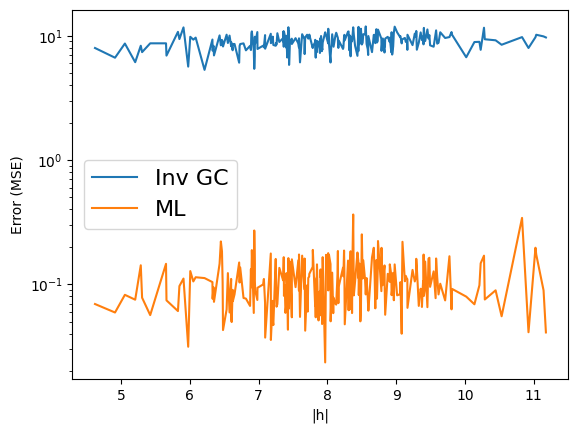

In [114]:
# Definición de estimadores
def rho1_to_h_gc(rho, beta, mu = 0):
    inv = scipy.linalg.inv(rho)
    mat = scipy.linalg.logm(inv-np.eye(inv.shape[0]))
    return (mat+mu)/beta

idx = np.random.randint(0,100)

iterador = iter(val_dataset)
sample = next(iterador)
rho_arr = sample[0][0]
prediction = model.predict(sample[0])
actual_values = sample[1]

# Ploteamos
## Eje X
sortids = np.array(np.linalg.norm(actual_values, axis=-1)).argsort().astype(int)
x = np.array(np.linalg.norm(actual_values, axis=-1))[sortids]
actual_values = actual_values.numpy()[sortids]

# Gráficos
inv_arr = np.array([np.diagonal(rho1_to_h_gc(r, beta, 0)) for r in rho_arr]).reshape(gpu_batch_size//2,basis.d)
ml_arr = prediction[sortids]
err = lambda a: np.linalg.norm(a-actual_values, axis=-1)

#%matplotlib inline
#plt.rcParams['text.usetex'] = True

plt.plot(x, err(inv_arr)[sortids], label='Inv GC')
plt.plot(x, err(ml_arr), label='ML')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300
plt.legend()
plt.xlabel('|h|')
plt.ylabel('Error (MSE)')
plt.yscale('log')

In [ ]:
for i, x in enumerate(min_actual_gm):
    if np.linalg.norm(x) < 10:
        print(x, min_num_gm[i])

In [ ]:
pre_const = lambda g: bcs_opti_cost_alt(g, dex, basis.m, state_type=state_type, h_type=h_type)
nl_const = scipy.optimize.NonlinearConstraint(pre_const, -0.1, 0.1)
cost = lambda g: np.linalg.norm(g-np.repeat(actual_values,2))
bounds = [(0.1, g_stop+0.5) for _ in range(basis.m)]

#opt = scipy.optimize.minimize(cost, np.random.rand(basis.m), constraints=nl_const, bounds=bounds, method='SLSQP')
opt = scipy.optimize.differential_evolution(cost, bounds=bounds, constraints=nl_const)
print(opt)
print(pre_const(opt.x), actual_values)


In [ ]:
# Buscamos delta_k   TODO: CASO TERMICO ENERGIA
#dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init, ord=2) + 0.01 * (delta_energ(delta_k, state_type)-actual_energy)**2
#bounds = [(0, 50) for _ in range(basis.m//2)] # Bounds de delta_k, TODO determinar o acotar
#opti = scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=1000)
#delta_k = opti.x
#print(delta_k, delta_r)

g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='vect')
bounds = [(g_init, g_stop), (0.01, 2.1)]
#optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000) broyden1!!
scipy.optimize.root(g_dist, (1,1), method='hybr', options={'maxiter': 10000})

In [ ]:
scipy.optimize.roots

In [ ]:
auto_delta(delta_r, state_type=state_type), delta_r

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='vect')
bounds = [(g_init, g_stop) for _ in range(basis.m//2)]
optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)
print(optig)
optig.x, sample[1][idx]

In [ ]:
dex, auto_delta(dex, state_type=state_type)

In [ ]:
rbcs = bcs_deltak_rho(dex, state_type=state_type)
np.linalg.eigvals(rbcs), np.linalg.eigvals(rho_init)
plt.plot(np.linalg.eigvals(rbcs))
plt.plot(np.linalg.eigvals(rho_init))
plt.yscale('log')

In [ ]:
nn = [0,1,2,None,np.inf,-1,-2]
for x in nn:
    d = dex
    print(np.linalg.norm(d, ord=x))

print(np.linalg.norm(d, ord=2)*2-np.linalg.norm(d, ord=1))

In [ ]:
bounds = [(0, 50) for _ in range(basis.m//2)]
scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=10000)

In [ ]:
dist = lambda delta_k: (bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init).numpy().flatten()
op = scipy.optimize.root(dist, np.random.rand(4), method='lm', tol=1e-8, epsfcn = 0.1)
op, delta_r
#delta_k = op.x
#type(dist(delta_r))

In [ ]:
op = scipy.optimize.fsolve(dist, np.random.rand(basis.m//2))
op

In [ ]:
rho_init

In [ ]:
dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init)+(np.linalg.norm(delta_k, ord=0)-basis.m//2)**2
bounds = [(0,10) for _ in range(4)]
opti = scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=10000)
delta_k = opti.x
print(dist(delta_r))

opti, delta_r
#g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='gaussvect')
#optig = scipy.optimize.dual_annealing(g_dist, bounds=[(0,10), (0,10)], maxiter=10000)
#optig, sample[1][idx]


In [ ]:
np.linalg.norm(delta_k, ord=0)

In [ ]:
nn = [0,1,2,None,np.inf,-1,-2]
for x in nn:
    print(np.linalg.norm(delta_r, ord=x))

In [ ]:
opti +

In [ ]:
#opti = scipy.optimize.differential_evolution(dist, bounds=bounds)
#opti
opti = scipy.optimize.direct(dist, bounds=bounds, maxiter=1000)
print(dist(delta_r))
opti

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='gaussvect')
boundss = [(0.01,20) for _ in range(2)]
optig = scipy.optimize.dual_annealing(g_dist, bounds=boundss, maxiter=1000)
sample[1][idx], optig, delta_r


In [ ]:
bcs_opti_cost(sample[1][idx], delta_r, state_type=state_type, h_type='gaussvect')

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='gaussvect')
opti = scipy.optimize.minimize(g_dist, np.random.rand(2), method='Nelder-Mead', tol=1e-8)
opti, sample[1][idx]

In [ ]:
g_dist(sample[1][rand_idx])

In [ ]:
plt.plot(np.linalg.eigvals(rho_init))

plt.plot(np.linalg.eigvals(bcs_deltak_rho(dex, basis.m)))

In [ ]:
delta_k = dex
# Calculamos el sistema de ecs
delta_k = np.abs(np.concatenate((delta_k, np.flip(delta_k)))) # pues el resultado son los delta indep
sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))

M = bcs_build_M(lambda k: uk(k) * vk(k))
M @ delta_k[:basis.m//2]

In [ ]:
arr = []
for i in range(0, 100):
    arr.append(rho_error_from_ge(actual_values.numpy(), sample[0][0][i]))
np.mean(arr)

In [ ]:
rho_init

In [ ]:
maxval = 100
# Cargamos elementos del conjunto de validación
iterador = iter(val_dataset)
sample = next(iterador)

input_rhos = sample[0][0].numpy()[:maxval]  
input_energies = sample[0][1].numpy()[:maxval] 
actual_values = sample[1].numpy()[:maxval]
input_data = sample[0]
predictions = model.predict(input_data)

# Ordenamos los valores de G con el fin de plotear
g_ids = actual_values[:,0].argsort()
g_ids = np.mean(actual_values, axis=-1).argsort()
predictions_sort = predictions[g_ids]
g_true_sort = actual_values[g_ids]
rho_pred = rho_reconstruction(predictions_sort)
rho_actual = input_rhos[g_ids]

# Calculamos ahora G BCS
rho_bcs_arr = []
for l in tqdm(range(actual_values.shape[0])): # equiv al batch_size
    rho = input_rhos[l]
    actual_energy = input_energies[l]
    gex, dex = opti_delta(rho, actual_energy,0)
    rho_bcs = rho_reconstruction(gex)
    #print(rho_bcs)
    rho_bcs_arr.append(rho_bcs)

rho_bcs = np.array(rho_bcs_arr)[g_ids]

rho_error = lambda x: np.linalg.norm(rho_actual-x, ord='fro', axis=(1,2))

plt.plot(g_true_sort[:,0], rho_error(rho_pred), label='DNN prediction') # ploteamos segun el primero
plt.plot(g_true_sort[:,0], rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.sort(np.mean(actual_values, axis=-1)), rho_error(rho_pred), label='CNN prediction') # ploteamos segun el primero
plt.plot(np.sort(np.mean(actual_values, axis=-1)), rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()

In [ ]:
rho_error = lambda x: np.linalg.norm(rho_actual-x, ord=2, axis=(1,2))

plt.plot(g_true_sort[:,0], rho_error(rho_pred), label='DNN prediction') # ploteamos segun el primero
plt.plot(g_true_sort[:,0], rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()

#### Análisis para G cte

In [ ]:
# Generacion de elementos, rho2 a partir de ellos, y comparación con la predicción
# Nuevamente, el resultado depende pura y exclusivamente del modelo, y no de los ptos tomados
h_labels = np.linspace(0.1,1,512)
g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
g_arr = tf.constant(g_arr, dtype=tf.float32)
h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)

# Estados térmicos
state = thermal_state_tf(h_arr*beta) 
state = tf.cast(state, dtype=tf.float32)
# Estados puros
#state = pure_state(h_arr)

rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
predictions = model.predict(rho_2_input).T
G_err = np.abs(predictions-h_labels).T
plt.plot(h_labels, G_err)

In [ ]:
# Ploteo de varios elementos de val_dataset
# No sirve de mucho, depende del modelo y no la muestra
max_plt = 10
idx = 0
for e in val_dataset:
    predictions = model.predict(e[0])
    pred_ids = predictions.T.argsort()
    predictions_sort = predictions[pred_ids][0]
    G_true_sorted = e[1].numpy()[pred_ids].T
    G_err = np.abs(predictions_sort-G_true_sorted)
    plt.plot(predictions_sort,G_err)
    idx += 1
    if idx > max_plt:  
        break


## Modelos Random Forest

Tenemos que trabajar con DataFrames para trabajar con xgboost, por eso inicialmente desempaquetamos el dataset 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np


def rf_fit(dataset):
    # Generación de dataset
    ds_f = {} # features
    ds_l = {} # labels

    # Generamos las etiquetas
    for i in range(basis.m*basis.m):
        ds_f[f'{i}'] = []
    # Generacion de labels TODO: Escribir todo en función del label size y fue
    if label_size == 1:
        ds_l['g'] = []
    elif label_size == 2:
        ds_l['g'] = []
        ds_l['sigma'] = []  
    else:
        for i in range(0, label_size):
            ds_l[f'l{i}'] = []

    # Poblamos el DF
    for e in list(dataset.as_numpy_iterator()):
        # Elementos de rho2
        for i in range(0,basis.m*basis.m):
            ds_f[f'{i}'].append(np.ndarray.flatten(e[0])[i])
        # Labels
        if label_size == 1:
            ds_l['g'].append(e[1])
        elif label_size == 2:
            ds_l['g'].append(e[1][0])
            ds_l['sigma'].append(e[1][1])
        else:
            for i in range(0, label_size):
                ds_l[f'l{i}'].append(e[1][i])

    ds_l = pd.DataFrame(ds_l)
    ds_f = pd.DataFrame(ds_f)

    # Spliteamos los datasets
    X_train, X_test, y_train, y_test = train_test_split(ds_f, ds_l, test_size=0.2, random_state=42)

    # Entrenamos
    regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=20)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)

    # Evaluamos
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    return regressor, X_test, y_test, y_train


Análicemos los resultados

In [ ]:
def rf_error_coef(regressor, X_test, y_test, y_train):
    predictions = regressor.predict(X_test)
    # Printeamos algunos valores
    for i in range(0, 10):
        print(predictions[i], y_test.to_numpy()[i])

    if label_size == 1:
        actual_values = y_test.to_numpy()
        norm_pred = np.mean(np.abs(predictions-actual_values.T))
        norm_rand = np.mean(np.abs(y_train.to_numpy()[:len(actual_values)]-actual_values))
    elif label_size > 1:
        norm_pred = np.mean(np.linalg.norm(predictions-y_test.to_numpy(),ord=2, axis=1))
        norm_rand = np.mean(np.linalg.norm(y_train.to_numpy()[:len(predictions)]-y_test.to_numpy(),ord=2, axis=1))
        
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    return norm_rand / norm_pred

# Análisis

Ejemplo de uso

In [ ]:
dataset, label_size = gen_dataset('const', 0.1, 5, 'thermal', 'rho1')
# DNN
#model, val_dataset = dnn_fit(dataset, label_size)
#dnn_error_coef(model, val_dataset) 
# RF
regressor, X_test, y_test, y_train = rf_fit(dataset)
rf_error_coef(regressor, X_test, y_test, y_train)

In [ ]:
# Barrido en intervalos de G para G cte
g_init_range = np.linspace(0.01,10,20)
err_arr = []
for g_init in g_init_range:
    print(g_init)
    dataset, label_size, input_type = gen_dataset('const', g_init, g_init+0.5, 'gs', 'rho1')
    # DNN
    model, val_dataset, history = dnn_fit(dataset, label_size, input_type)
    err = dnn_error_coef(model, val_dataset)
    # RF
    #regressor, X_test, y_test, y_train = rf_fit(dataset)
    #err = rf_error_coef(regressor, X_test, y_test, y_train)
    err_arr.append(err)

plt.plot(g_init_range,err_arr)

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('G init')
plt.ylabel('Loss coef')
plt.plot(g_init_range,err_arr)

# Misc

In [ ]:
from xgboost import plot_tree
import matplotlib 
xgb.plot_tree(regressor, num_trees=20)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')


In [ ]:
# Para G cte, error en función de G. Sí, es cualquier cosa
import matplotlib.pyplot as plt

pred_ids = predictions.T.argsort()
predictions_sort = predictions[pred_ids]
G_true_sorted = y_test.to_numpy()[pred_ids].T[0]
G_err = np.abs(predictions_sort-G_true_sorted)
plt.plot(predictions_sort,G_err)

In [ ]:
# Spliteo de DataFrames y generacion de Datasets
label = 'h_labels'

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

# Entrenamiento
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
model.compile(metrics=["mse"]) 
model.fit(x=train_ds)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.compile(metrics=["mse"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

predictions = model.predict(test_ds)

for e in test_ds:
    for i in range(0, 10):
        print(e[1][i])
        print(predictions[i])
    break


In [ ]:
import matplotlib.pyplot as plt
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

Testeo barrido en G código anterior

In [ ]:
num = 100
g_range = np.linspace(0.01,20,num)
rho_range= {}
gpu_batch_size = 2

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)

batch_size = 2
indices = tf.constant(get_kkbar_indices(t_basis))
indices_tf = gen_update_indices(t_basis, batch_size)
en_batch = [np.arange(0, basis.m) for _ in range(0,batch_size)]
en_batch = tf.cast(en_batch, dtype=tf.float32)
G_batched = [np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]

#h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)
#(h0, hi) = (t[0][0].numpy(), t[1][0].numpy())



In [ ]:
def compute_g(g):
    #print(g)
    ## CONST
    #G_batched = [g * np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]
    ## GAUSSIAN
    h_labels = np.array([[g, 1] for _ in range(0, gpu_batch_size)])
    g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
    h_labels = tf.constant(h_labels, dtype=tf.float32)
    G_batched = tf.constant(g_arr, dtype=tf.float32)

    G_batched = tf.cast(G_batched, dtype=tf.float32)
    t = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, G_batched, rho_1_arrays, rho_2_arrays, indices_tf)
    state = pure_state(t)
    #print(fund)
    #print('rho')
    #Toda la matriz
    rho = rho_2_tf(state, rho_2_arrays_kkbar_tf)
    #Solo el bloque kkbar
    #rho = rho_2_kkbar(basis, fund, ml_basis, mll_basis, t_basis)
    #Rho1
    #rho = rho_1(basis, fund).todense()
    r = np.sort(linalg_d.eigvals(rho[0]).real)
    #print(r)
    return (g, r)

# Version sincrónica
rho_range = {}

for g in g_range:
    print(g)
    rho_range[g] = compute_g(g)


In [ ]:
# Ploteamos
rho_range = dict(rho_range)
rho_range = dict(sorted(rho_range.items()))
x_axis = list(g_range)
values = list(rho_range.items())
size = len(values[0][1])
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Plot using matplotlib
# Use LaTeX to format all text

plt.rcParams['text.usetex'] = False #True
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.linewidth'] = 1.5

plt.cla()
plt.figure(figsize=(8, 5))
#%matplotlib qt
%matplotlib inline 
for k in range(1,size):
    plt.plot(x_axis, [values[j][1][k] for j in range(0,num)], linewidth=2)

#plt.xlabel(r'$G/\epsilon$', fontsize=18)
#plt.ylabel(r'$\lambda^{(2)}$', fontsize=18)
plt.xlim(0, 20)  # Set x-axis limits from 0 to 6
plt.ylim(0, 5)  # Set y-axis limits from 5 to 12

#matplotlib.use('Agg')
#matplotlib.use('GTK3Agg')

plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)

# Enable minor ticks on the x-axis
plt.minorticks_on()

# Customize the appearance of minor ticks on the x-axis
plt.tick_params(axis='x', which='minor', width=1.5)
plt.tick_params(axis='x', which='major', width=1.5)
plt.tick_params(axis='y', which='major', width=1.5)

plt.show()
matplotlib.pyplot.savefig('filename.png')
